# COVID-19 v České republice

__TODO:__
- odečíst 12% pro opakovaně testované
- ~~přidat sem denní data z druhého notebooku~~
- ~~zobrazovat grafy v mřížce 2 x 2~~
- ~~jak zobrazovat datum u grafů, které kreslím Matplotlibem?~~
- ~~udělat grafy vývoje aktivních případů (protože sbírám data o uzdravených a úmrtí)~~
- zobrazovat denní poměr testovaných pozitivně/testovaných celkem a jeho vývoj


Na Raspi:
- ~~sbírat i základní data pro tento notebook s apify a mít tam vždy aktuální v ejdnom souboru (historii asi zachovat)~~
- možná by se některé dopočty na datech mohly dělat na Raspi a ne v notebooku tady


In [43]:
!scp pi@192.168.1.29:/home/pi/covid/daily_data.csv .
!scp pi@192.168.1.29:/home/pi/covid/total_positive_tests.csv .
!scp pi@192.168.1.29:/home/pi/covid/number_of_tested.csv .
!scp pi@192.168.1.29:/home/pi/covid/infected_by_region.csv .
!scp pi@192.168.1.29:/home/pi/covid/infected_daily.csv .


daily_data.csv                                100% 1224   169.8KB/s   00:00    
total_positive_tests.csv                      100% 1217   247.3KB/s   00:00    
number_of_tested.csv                          100% 1328   246.3KB/s   00:00    
infected_by_region.csv                        100%  335    63.7KB/s   00:00    
infected_daily.csv                            100% 1175   239.7KB/s   00:00    


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import urllib.request
import json

with urllib.request.urlopen("https://api.apify.com/v2/key-value-stores/K373S4uCFR9W1K8ei/records/LATEST?disableRedirect=true") as url:
    data = json.loads(url.read().decode())
    

totalPositiveTests = pd.DataFrame(data['totalPositiveTests'])
totalPositiveTests['date'] = pd.to_datetime(totalPositiveTests['date'], errors='coerce')
totalPositiveTests['date'] = totalPositiveTests['date'].dt.date
#totalPositiveTests = pd.read_csv('total_positive_tests.csv')

numberOfTested = pd.DataFrame(data['numberOfTestedGraph'])
numberOfTested['date'] = pd.to_datetime(numberOfTested['date'], errors='coerce')
numberOfTested['date'] = numberOfTested['date'].dt.date
#numberOfTested = pd.read_csv('number_of_tested.csv')

infectedByRegion = pd.DataFrame(data['infectedByRegion'])
#infectedByRegion = pd.read_csv('infected_by_region.csv')
infectedByRegion.set_index('name', inplace = True) 


infectedDaily = pd.DataFrame(data['infectedDaily'])  
infectedDaily['date'] = pd.to_datetime(infectedDaily['date'], errors='coerce')
infectedDaily['date'] = infectedDaily['date'].dt.date
#infectedDaily = pd.read_csv('infected_daily.csv')

daily = pd.read_csv('daily_data.csv')    


#plt.style.use('bmh')
plt.style.use('ggplot')

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline
import urllib.request
import json


totalPositiveTests = pd.read_csv('total_positive_tests.csv')

numberOfTested = pd.read_csv('number_of_tested.csv')

infectedByRegion = pd.read_csv('infected_by_region.csv')
infectedByRegion.set_index('name', inplace = True) 

infectedDaily = pd.read_csv('infected_daily.csv')

daily = pd.read_csv('daily_data.csv')    


plt.style.use('ggplot')

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

## Základní data

In [5]:
#print(f'Celkový počet testovaných: {data["totalTested"]}')
#print(f'Celkový počet pozitivně testovaných: {data["infected"]}')
#print(f'Celkový počet aktivních případů: {data["infected"]-data["recovered"]-data["deceased"]}')
#print(f'Celkový počet vyléčených: {data["recovered"]}')
#print(f'Celkový počet mrtvých: {data["deceased"]}')

## Vývoj počtu pozitivně testovaných

In [6]:
infectedDaily.tail()

,value,date
86,99,2020-04-22
87,55,2020-04-23
88,86,2020-04-24
89,79,2020-04-25
90,52,2020-04-26


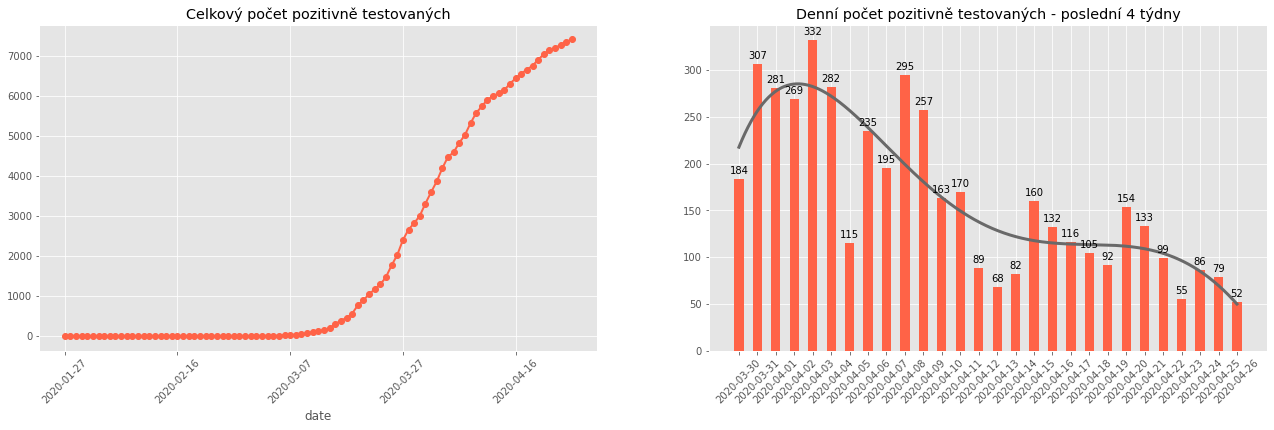

In [7]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

totalPositiveTests.plot(x='date', 
                        y='value', 
                        kind='line', 
                        style='tomato',
                        marker='o',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(infectedDaily.iloc[-days_back:, 1]) #.index) #daily['date']
y = np.array(infectedDaily.iloc[-days_back:, 0]) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet pozitivně testovaných - poslední 4 týdny')

plt.show()

In [8]:
infectedDaily.tail()

,value,date
86,99,2020-04-22
87,55,2020-04-23
88,86,2020-04-24
89,79,2020-04-25
90,52,2020-04-26


In [9]:
# count daily tested cases (included repeated tests)
numberOfTested['daily'] = numberOfTested['value'] - numberOfTested['value'].shift(1)
# count growth factor 
infectedDaily['growthFactor'] = infectedDaily['value'] / infectedDaily['value'].shift(1)
infectedDaily['ones'] = 1

In [13]:
numberOfTested.tail()

,value,date,daily
86,195733,2020-04-22,8815.0
87,203632,2020-04-23,7899.0
88,210705,2020-04-24,7073.0
89,215116,2020-04-25,4411.0
90,218474,2020-04-26,3358.0


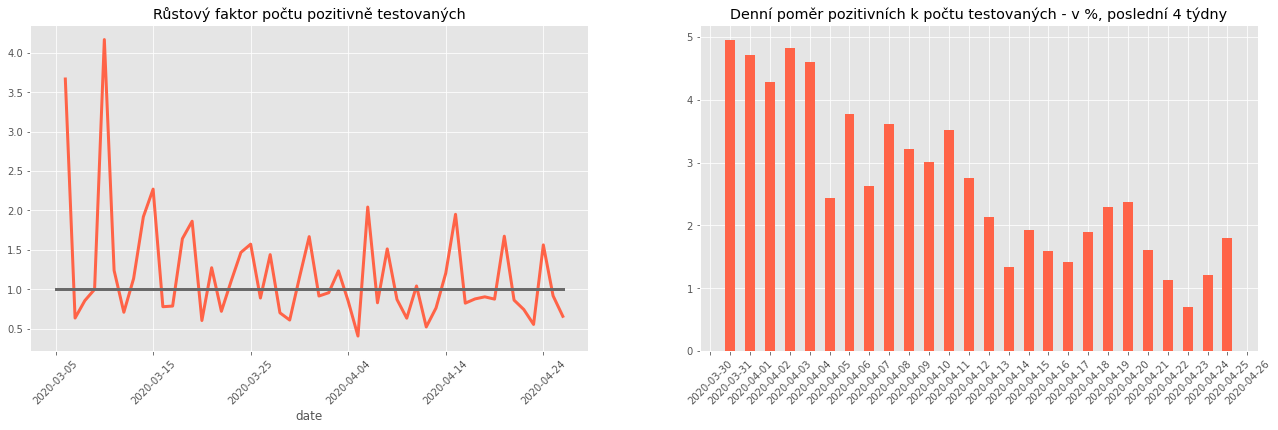

In [10]:
# interpoolace křivkou

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

infectedDaily[38:].plot(x='date', 
                    y=['growthFactor','ones'], 
                    kind='line',
                    style=['tomato', 'dimgray'],
                    linewidth=3,
                    #marker=['o',],
                    grid=True, 
                    legend=False,
                    ax=ax1,                        
                    title='Růstový faktor počtu pozitivně testovaných')
ax1.tick_params(axis="x", rotation=45) 

x = np.arange(days_back)
x_labels = np.array(infectedDaily.iloc[-days_back:, 1]) #.index) #daily['date']
y = np.array(100*(infectedDaily.iloc[-days_back+1:-1, 0]  / numberOfTested.iloc[-days_back:, 2])) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

#rects1 = ax2.bar(x, y, color='red')

ax2.bar(x, y, width=.5, color='tomato')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
#autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'dimgray', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní poměr pozitivních k počtu testovaných - v %, poslední 4 týdny')
plt.show()

In [11]:
y

array([       nan, 4.94682565, 4.7045036 , 4.27594977, 4.81927711,
       4.59732638, 2.44161359, 3.77025509, 2.62308313, 3.61342479,
       3.20889   , 3.0012889 , 3.51167114, 2.75286112, 2.13634936,
       1.33768352, 1.92030725, 1.58978682, 1.4101629 , 1.88747079,
       2.28457909, 2.37141977, 1.6022166 , 1.12308565, 0.69629067,
       1.21589142, 1.7909771 ,        nan])

## Vývoj počtu testovaných

In [12]:
numberOfTested.tail()

,value,date,daily
86,195733,2020-04-22,8815.0
87,203632,2020-04-23,7899.0
88,210705,2020-04-24,7073.0
89,215116,2020-04-25,4411.0
90,218474,2020-04-26,3358.0


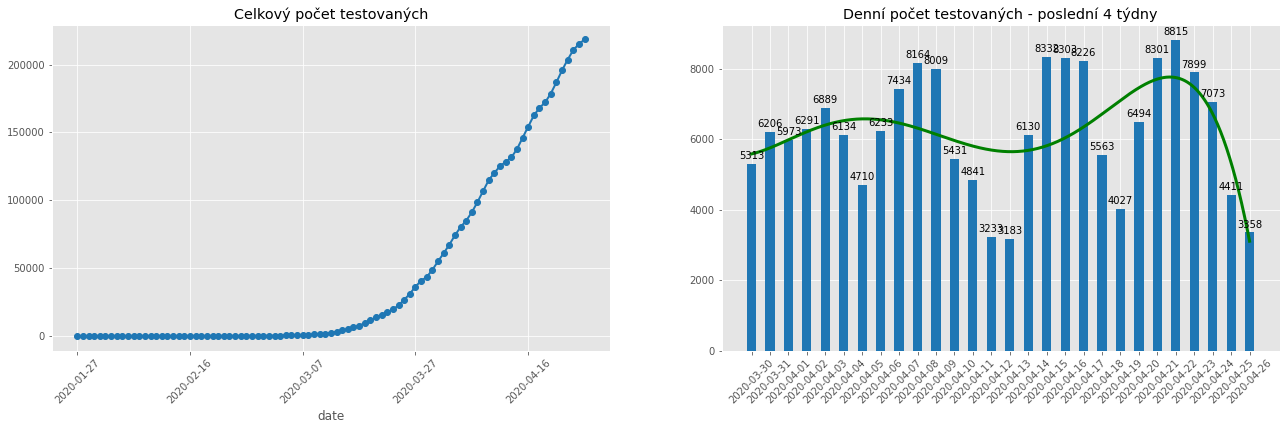

In [7]:
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

numberOfTested.plot(x='date', 
                        y='value', 
                        kind='line', 
                        style='tab:blue',
                        marker='o',
                        #color='royalblue',
                        linewidth=2,                   
                        legend=False,
                        grid=True, 
                        ax=ax1,
                        title='Celkový počet testovaných')
ax1.tick_params(axis="x", rotation=45) 

days_back = 28

x = np.arange(days_back)
x_labels = np.array(numberOfTested.iloc[-days_back:, 1]) #.index) #daily['date']
y = np.array(numberOfTested.iloc[-days_back:, 2]) ## -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax2.bar(x, y, width=.5, color='tab:blue')
ax2.set_xticks(np.arange(len(x)))
ax2.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax2)

ax2.plot(xnew, p(xnew), 'g-', linewidth=3)

ax2.grid(True)
ax2.set_title('Denní počet testovaných - poslední 4 týdny')

plt.show()

## Vývoj průměrného denního nárůstu pozitivně testovaných 

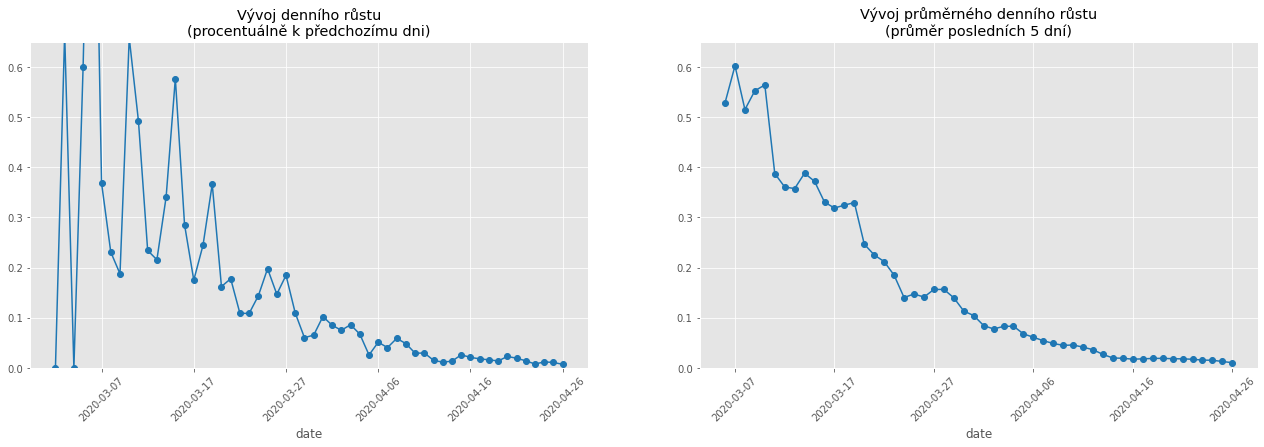

In [8]:
totalPositiveTests['increase']=0
df = totalPositiveTests
totalPositiveTests['increase'] = (totalPositiveTests['value'] - \
                                  totalPositiveTests['value'].shift(1)) / \
                                  totalPositiveTests['value'].shift(1)
totalPositiveTests['increase5days'] = (totalPositiveTests['increase'] + \
                                       totalPositiveTests['increase'].shift(1) + \
                                       totalPositiveTests['increase'].shift(2) + \
                                       totalPositiveTests['increase'].shift(3) + \
                                       totalPositiveTests['increase'].shift(4)) / 5
#totalPositiveTests.tail()

fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df.plot(x='date',
             y='increase', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax1,
             title='Vývoj denního růstu\n(procentuálně k předchozímu dni)')
ax1.tick_params(axis="x", rotation=45) 

df.plot(x='date',
             y='increase5days', 
             kind='line', 
             grid=True, 
             legend=False,
             ylim=(0,0.65),
             style='tab:blue',
             marker='o',
             ax=ax2,
             title='Vývoj průměrného denního růstu\n(průměr posledních 5 dní)')
ax2.tick_params(axis="x", rotation=45) 


plt.show()


# Počty uzdravených a zemřelých

Poslední den 2020-04-27 (neúplná data): 10 uzdravených, 1 zemřelých


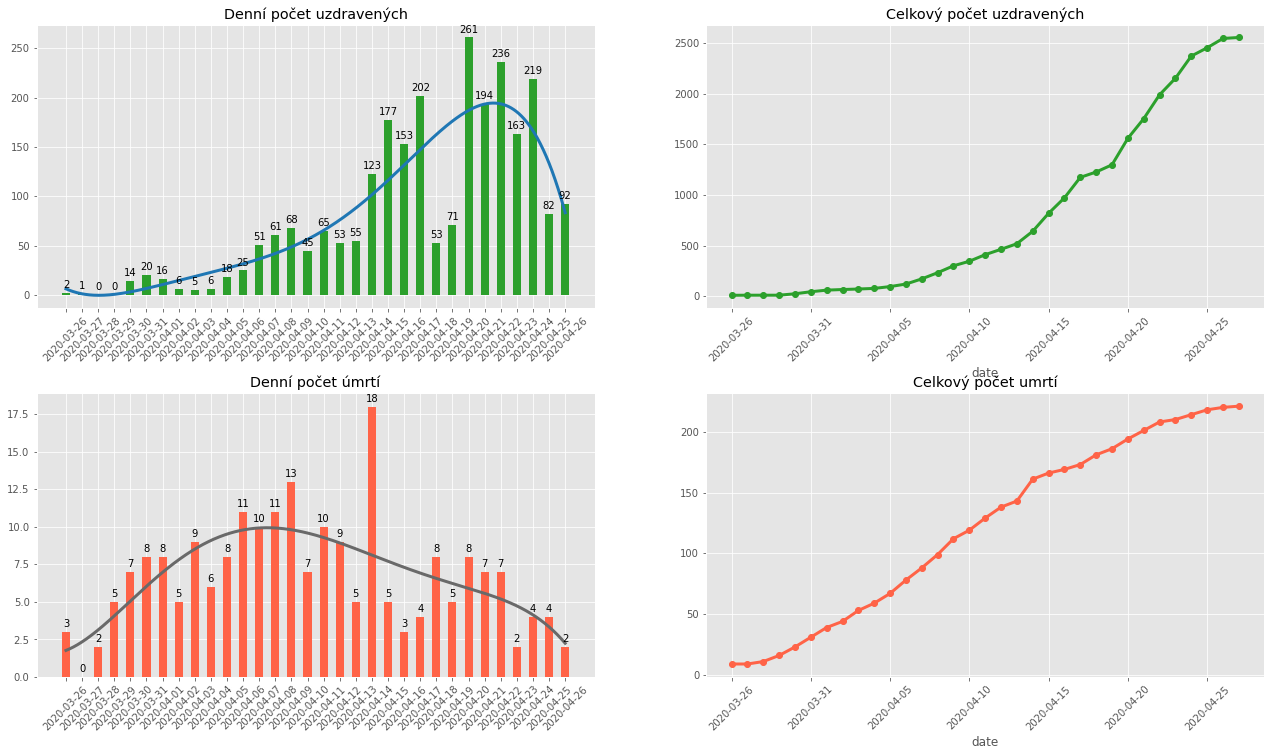

In [9]:
print(f'Poslední den {daily.iloc[-1, 0]} (neúplná data): {daily.iloc[-1,6]} uzdravených, {daily.iloc[-1,8]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(len(daily)-1)
x_labels = np.array(daily.iloc[:-1,0]) #.index) #daily['date']
y = np.array(daily.iloc[:-1, 6]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title('Denní počet uzdravených')
plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalRecovered', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(len(daily)-1)
x_labels = np.array(daily.iloc[:-1, 0]) #.index) #daily['date']
y = np.array(daily.iloc[:-1, 8]) ## deceased bez posledního dne (neúplná data)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title('Denní počet úmrtí')
#plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalDeceased', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

Poslední den 2020-04-27 (neúplná data): 10 uzdravených, 1 zemřelých


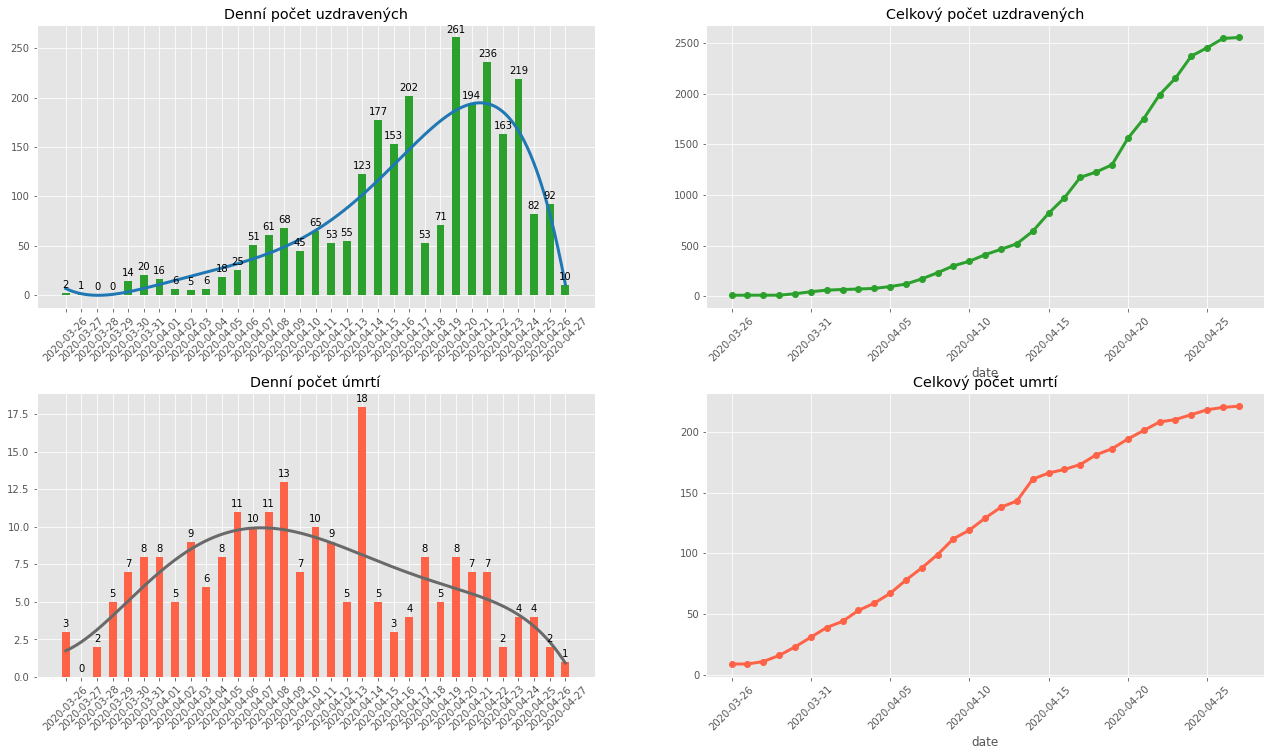

In [10]:
print(f'Poslední den {daily.iloc[-1, 0]} (neúplná data): {daily.iloc[-1,6]} uzdravených, {daily.iloc[-1,8]} zemřelých')
fig = plt.figure(figsize=(22,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

x = np.arange(len(daily))
x_labels = np.array(daily.iloc[:,0]) #.index) #daily['date']
y = np.array(daily.iloc[:, 6]) ## 'recovered' -28: = poslední 4 týdny, 0 = beru jen pole s indexem 0 (value)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects1 = ax1.bar(x, y, width=.5, color='tab:green')
ax1.set_xticks(np.arange(len(x)))
ax1.set_xticklabels(x_labels, rotation=45)
autolabel(rects1, ax1)

ax1.plot(xnew, p(xnew), 'tab:blue', linewidth=3)
ax1.set_title('Denní počet uzdravených')
plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalRecovered', 
            kind='line',
            linewidth=3,
            style='tab:green',
            marker='o',
            grid=True, 
            legend=False,
            ax=ax2,
            title='Celkový počet uzdravených')
ax2.tick_params(axis="x", rotation=45)

x = np.arange(len(daily))
x_labels = np.array(daily.iloc[:, 0]) #.index) #daily['date']
y = np.array(daily.iloc[:, 8]) ## deceased bez posledního dne (neúplná data)

z = np.polyfit(x,y,5)
p = np.poly1d(z)
xnew = np.linspace(x[0], x[-1], 1000)

rects2 = ax3.bar(x, y, width=.5, color='tomato')
ax3.set_xticks(np.arange(len(x)))
ax3.set_xticklabels(x_labels, rotation=45)
autolabel(rects2, ax3)

ax3.plot(xnew, p(xnew), 'dimgray', linewidth=3)
ax3.set_title('Denní počet úmrtí')
#plt.subplots_adjust(hspace=0.3)

daily.plot(x='date', 
            y='totalDeceased', 
            kind='line',
            linewidth=3,
            style='tomato',
            marker='o',
            grid=True,
            legend=False,
            ax=ax4,
            title='Celkový počet umrtí')
ax4.tick_params(axis="x", rotation=45)

plt.show()

# Celkový počet pozitivně testovaných vs. aktivní případy

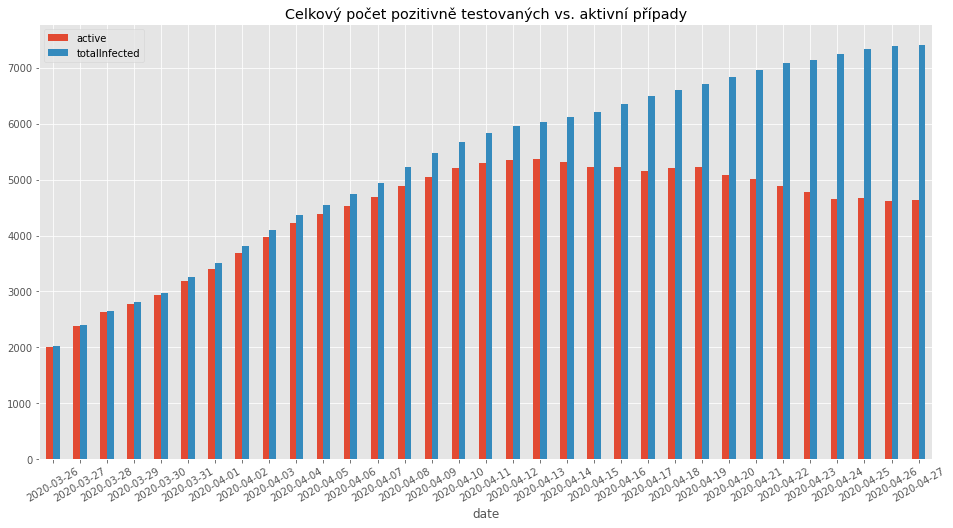

In [11]:
daily['active'] = daily['totalInfected'] - daily['totalRecovered'] - daily['totalDeceased'] 

daily.plot(x='date', 
            y=['active', 'totalInfected'], 
            kind='bar', 
            #style='r+-',
            figsize=(16, 8),
            grid=True, 
            title='Celkový počet pozitivně testovaných vs. aktivní případy')
plt.xticks(rotation=30)
plt.show()

In [12]:
daily.iloc[-10:]

,date,totalTested,tested,totalInfected,infected,totalRecovered,recovered,totalDeceased,deceased,active
23,2020-04-18,162533,8226,6606,107,1227,53,181,8,5198
24,2020-04-19,168096,5563,6701,95,1298,71,186,5,5217
25,2020-04-20,172123,4027,6838,137,1559,261,194,8,5085
26,2020-04-21,178617,6494,6961,123,1753,194,201,7,5007
27,2020-04-22,186918,8301,7087,126,1989,236,208,7,4890
28,2020-04-23,195725,8807,7138,51,2152,163,210,2,4776
29,2020-04-24,203622,7897,7236,98,2371,219,214,4,4651
30,2020-04-25,210705,7083,7333,97,2453,82,218,4,4662
31,2020-04-26,215116,4411,7387,54,2545,92,220,2,4622
32,2020-04-27,218474,3358,7404,17,2555,10,221,1,4628


# Počet infikovaných podle krajů

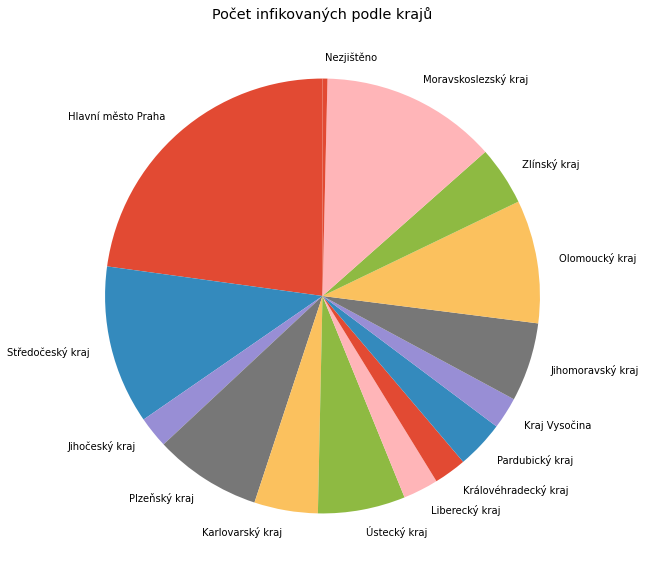

In [13]:
infectedByRegion.plot.pie(y='value', 
                          figsize=(10, 10), 
                          startangle=90, 
                          title="Počet infikovaných podle krajů", 
                          legend=False, 
                          label='')
plt.show()

Počty podle krajů. Ale je třeba odečítat z počtů testovaných asi 12%, protože to jsou přibližně opakované testy. Otázka je, zda to změní ten poměr. Asi by ani nemělo.

In [14]:
infectedByRegion.loc['Hlavní město Praha', 'citizens'] = 1309000
infectedByRegion.loc['Středočeský kraj', 'citizens'] = 1369000
infectedByRegion.loc['Jihočeský kraj', 'citizens'] = 642000
infectedByRegion.loc['Plzeňský kraj', 'citizens'] = 585000
infectedByRegion.loc['Karlovarský kraj', 'citizens'] = 295000
infectedByRegion.loc['Ústecký kraj', 'citizens'] = 821000
infectedByRegion.loc['Liberecký kraj', 'citizens'] = 442000
infectedByRegion.loc['Královéhradecký kraj', 'citizens'] = 551000
infectedByRegion.loc['Pardubický kraj', 'citizens'] = 520000
infectedByRegion.loc['Kraj Vysočina', 'citizens'] = 509000
infectedByRegion.loc['Jihomoravský kraj', 'citizens'] = 1189000
infectedByRegion.loc['Olomoucký kraj', 'citizens'] = 633000
infectedByRegion.loc['Zlínský kraj', 'citizens'] = 583000 
infectedByRegion.loc['Moravskoslezský kraj', 'citizens'] = 1203000
infectedByRegion.loc['Nezjištěno', 'citizens'] = 200000

infectedByRegion['ratio'] = 100*(infectedByRegion.loc[:, 'value'] / totalPositiveTests.iloc[-1,0])
infectedByRegion['county_ratio'] = 1e5 * (infectedByRegion.loc[:, 'value'] / infectedByRegion.loc[:, 'citizens'])
display(infectedByRegion)

,value,citizens,ratio,county_ratio
name,,,,
Hlavní město Praha,1690,1309000.0,22.825500,129.106188
Středočeský kraj,873,1369000.0,11.790924,63.769175
Jihočeský kraj,173,642000.0,2.336575,26.947040
Plzeňský kraj,591,585000.0,7.982172,101.025641
Karlovarský kraj,350,295000.0,4.727175,118.644068
Ústecký kraj,481,821000.0,6.496488,58.587089
Liberecký kraj,194,442000.0,2.620205,43.891403
Královéhradecký kraj,179,551000.0,2.417612,32.486388
Pardubický kraj,264,520000.0,3.565640,50.769231


In [15]:
# procento pozitivně testovaných podle krajů (pole ratio)
infectedByRegion.sort_values(by=['ratio'], ascending=False)

,value,citizens,ratio,county_ratio
name,,,,
Hlavní město Praha,1690,1309000.0,22.825500,129.106188
Moravskoslezský kraj,970,1203000.0,13.101026,80.631754
Středočeský kraj,873,1369000.0,11.790924,63.769175
Olomoucký kraj,678,633000.0,9.157212,107.109005
Plzeňský kraj,591,585000.0,7.982172,101.025641
Ústecký kraj,481,821000.0,6.496488,58.587089
Jihomoravský kraj,434,1189000.0,5.861696,36.501262
Karlovarský kraj,350,295000.0,4.727175,118.644068
Zlínský kraj,325,583000.0,4.389519,55.746141


In [16]:
# počet pozitivně testovaných na 100 000 obyvatel podle krajů (pole county_ratio)
infectedByRegion.sort_values(by=['county_ratio'], ascending=False)

,value,citizens,ratio,county_ratio
name,,,,
Hlavní město Praha,1690,1309000.0,22.825500,129.106188
Karlovarský kraj,350,295000.0,4.727175,118.644068
Olomoucký kraj,678,633000.0,9.157212,107.109005
Plzeňský kraj,591,585000.0,7.982172,101.025641
Moravskoslezský kraj,970,1203000.0,13.101026,80.631754
Středočeský kraj,873,1369000.0,11.790924,63.769175
Ústecký kraj,481,821000.0,6.496488,58.587089
Zlínský kraj,325,583000.0,4.389519,55.746141
Pardubický kraj,264,520000.0,3.565640,50.769231


In [17]:
infectedByRegion.loc[:,'value']

name
Hlavní město Praha      1690
Středočeský kraj         873
Jihočeský kraj           173
Plzeňský kraj            591
Karlovarský kraj         350
Ústecký kraj             481
Liberecký kraj           194
Královéhradecký kraj     179
Pardubický kraj          264
Kraj Vysočina            175
Jihomoravský kraj        434
Olomoucký kraj           678
Zlínský kraj             325
Moravskoslezský kraj     970
Nezjištěno                27
Name: value, dtype: int64